Beginning date of Gantt chart? (mm/dd/yyyy) or type "today". today
End Date of the Gantt chart? (mm/dd/yyyy) or type "end" for the full length schedule. 8/6/2023


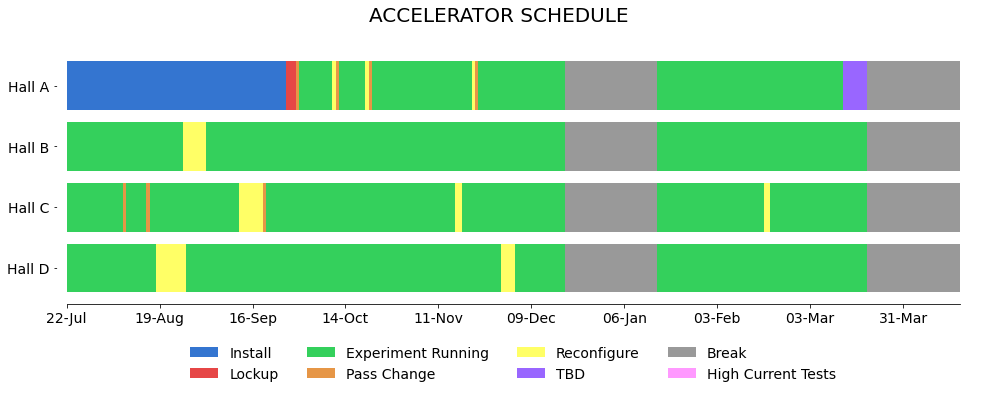

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import csv

with open('practice3.csv', 'r') as s:
    sched = list(csv.DictReader(s))

    
    def format_date(d):
        """ Converts the date from mm/dd/yyyy format to yyyy-mm-dd format 
        (used by the datetime module) """
        # We need to format the dates because that's what is used easier in the chart
        assert len(d) > 0    # Make sure there is a date, or something given
        month, day, year = d.split('/')
        d = dt.date(int(year), int(month), int(day))
        return d
    
    
    def find_date(date):
        """ Binary search for the index of the date in the list of dates """
        first = 0
        last = len(sched)-1
        found = False

        while first <= last and not found:
            pos = 0
            midpoint = (first + last)//2
            if sched[midpoint]['Date'] == date:
                pos = midpoint
                found = True
            else:
                if date < sched[midpoint]['Date']:
                    last = midpoint-1
                else:
                    first = midpoint+1
        return pos
    
    
    # pop out any lines without data
    for i in range(0, len(sched)-1):
        if i >= len(sched):
            break
        def p(): # Recursive function so we don't skip any lines
            if len(sched[i]['Date']) == 0:
                sched.pop(i)
                p()
        p()
    
    
    # Get user inputted start and end dates
    beginning = str(input("Beginning date of Gantt chart? (mm/dd/yyyy) or type \"today\"."))
    end = str(input("End Date of the Gantt chart? (mm/dd/yyyy) or type \"end\" for the full length schedule."))
    if beginning.lower() in ['now', 'today', 'to', 'day', 't', 'tod', 'toda']:
        beginning = dt.date.today()
    else:
        beginning = format_date(beginning)
    if end.lower() in ['e', 'end', 'en', 'last', 'full', 'all', 'ends', 'nd', 'n', 'd']:
        end = format_date(sched[len(sched)-1]['Date'])
    else:
        end = format_date(end)
    
    
    # format all dates with datetime module
    for line in sched:
        line['Date'] = format_date(line['Date']) 
    
    
    # truncate sched list to beginning and end
    sched = sched[find_date(beginning) : find_date(end)+1]
    
    total_start = sched[0]['Date']
    total_end = sched[len(sched)-1]['Date']
    total_duration = int((total_end - total_start).days)

    
    #xticks
    x_ticks=[i for i in range(0, total_duration+1, 28 )]   # Third number = how many days between each x-tick label
    #xtick labels starts with project start date, formatted dd-mon
    x_labels=[(total_start+dt.timedelta(days=i)).strftime('%d-%b') 
          for i in x_ticks]
        
        
    def hall_gantt(hall):
        # make an array of values for the dates and names of experiments and durations for chart
        start = [sched[0]['Date']]
        end = []
        name = []
        duration = []
        for line in range(0, len(sched)-1):

            if not sched[line]['Hall ' + hall + ' Exp'] == sched[line+1]['Hall ' + hall + ' Exp']:
                end.append(sched[line]['Date'])
                start.append(sched[line+1]['Date'])
                if sched[line]['Hall ' + hall + ' Exp'] == '':
                    name.append("Break")
                else:
                    name.append(sched[line]['Hall ' + hall + ' Exp'])
                    
            if line == len(sched)-2:      # To get the very last section :)
                end.append(sched[line+1]['Date'])
                if sched[line+1]['Hall ' + hall + ' Exp'] == '':
                    name.append("Break")
                else:
                    name.append(sched[line+1]['Hall ' + hall + ' Exp'])
    
        rel_start = [(start[i]-total_start).days for i in range(len(start))]

        # set all the durations (widths in the Gantt chart)
        for i in range(len(start)):
            duration.append(int((end[i]-start[i]).days+1))

        return name, start, end, duration, rel_start

    
    def get_colors(names):
        colors = []
        for name in names:
            if name == 'Break':
                colors.append('#999999')
            elif name.lower() in ['reconfigure', 'target reconfiguration']:
                colors.append('#FFFF66')
            elif name.lower() == 'pass change':
                colors.append('#E69646')
            elif name.lower() in ['install', 'installation']:
                colors.append('#3475D0')
            elif name.lower() in ['high current test', 'high current tests']:
                colors.append('#FF99FF')
            elif name.lower() == 'lockup':
                colors.append('#E64646')
            elif name.lower() == 'tbd':
                colors.append('#9966FF')
            else:
                colors.append('#34D05C')
        return colors
    
    
    def main():

        nameA, startA, endA, durationA, rel_startA = hall_gantt('A')
        nameB, startB, endB, durationB, rel_startB = hall_gantt('B')
        nameC, startC, endC, durationC, rel_startC = hall_gantt('C')
        nameD, startD, endD, durationD, rel_startD = hall_gantt('D')
        
        colorsA = get_colors(nameA)
        colorsB = get_colors(nameB)
        colorsC = get_colors(nameC)
        colorsD = get_colors(nameD)

        halls = ['Hall D', 'Hall C', 'Hall B', 'Hall A']
        
        ##### PLOT #####
        with plt.rc_context({'ytick.color':'k', 'font.size': 14.0}):   ## The only I could get the y-ticks to be in white, for some crazy code reason (maybe jupyter problem?)
            fig, (ax, ax1) = plt.subplots(2, figsize=(16, 6), gridspec_kw={'height_ratios': [6, 1]}, facecolor='#FFFFFF')
            ax.set_facecolor('#FFFFFF')
            ax1.set_facecolor('#FFFFFF')
            # bars
            #ax.barh(df.Experiment, df.current_num, left=df.start_num, color=df.color)
            ax.barh(4, width=durationA, left=rel_startA, color=colorsA, alpha=1)
            ax.barh(3, width=durationB, left=rel_startB, color=colorsB, alpha=1)
            ax.barh(2, width=durationC, left=rel_startC, color=colorsC, alpha=1)
            ax.barh(1, width=durationD, left=rel_startD, color=colorsD, alpha=1)


            # grid lines
            ax.set_axisbelow(True)
            #ax.xaxis.grid(color='w', linestyle='dashed', alpha=0.4, which='both')   # Uncomment for dashed x grid


            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels, color='black', fontsize=14)
            ax.set_yticks([1, 2, 3, 4])
            ax.set_yticklabels(halls, color='black', fontsize=14)
            ax.tick_params(color='k', which='both')

            plt.setp([ax.get_yticklabels()], color='k')

            # align x axis
            ax.set_xlim(0, find_date(total_end))

            # remove spines
            ax.spines['right'].set_position(('outward', 30))
            ax.spines['right'].set_visible(True)
            ax.spines['right'].set_color('#FFFFFF')
            ax.spines['left'].set_color('#FFFFFF')
            ax.spines['left'].set_position(('outward', 10))
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_color('black')

            plt.suptitle('ACCELERATOR SCHEDULE', color='k', fontsize=20)

            ##### LEGENDS #####
            legend_elements = [Patch(facecolor='#3475D0', label='Install'),
                               Patch(facecolor='#E64646', label='Lockup'),
                               Patch(facecolor='#34D05C', label='Experiment Running'),
                               Patch(facecolor='#E69646', label='Pass Change'),
                               Patch(facecolor='#FFFF66', label='Reconfigure'),
                               Patch(facecolor='#9966FF', label='TBD'),
                               Patch(facecolor='#999999', label='Break'),
                               Patch(facecolor='#FF99FF', label='High Current Tests')]

            legend = ax1.legend(handles=legend_elements, loc='upper center', ncol=4, frameon=False, fontsize=14)
            plt.setp(legend.get_texts(), color='k')

            # clean second axis
            ax1.spines['right'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.spines['top'].set_visible(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.set_xticks([])
            ax1.set_yticks([])

            plt.savefig('gantt.png', facecolor='#FFFFFF', bbox_inches='tight')
            plt.show()
        
        
    main()

In [115]:
import matplotlib.pyplot as plt
print(plt.rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri